<a href="https://colab.research.google.com/github/Serbeld/Tensorflow/blob/master/Nuevas_imagenes_de_Inception_v3_Drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network 

Build a CNN using Tensorflow and Keras to classify Towers. The Inspection_320x240 dataset consists in 22000 colour images, divided in 2 classes. There are 15399 training images, 3001 validation images and 3000 test images.


- Author: Sergio Luis Beleño Díaz
- Date: 2020-03-25



## Setup


Install and import TensorFlow and dependencies:


In [0]:
!pip install h5py
import h5py

from google.colab import drive,files
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Serbeld_Drone/DATASET/Dataset_320x240_and_Code')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
hdf5_path = '/content/drive/My Drive/Serbeld_Drone/DATASET/Dataset_320x240_and_Code/Inspection_320x240.hdf5'

dataset = h5py.File(hdf5_path, "r")

In [0]:
!pip install tensorflow==1.15.0
!pip install keras==2.3.1

## Exploratory Data Analysis

In [0]:
# Parameters
batch_size = 10
num_classes = 2
num_epochs = 10

lrate = 2e-5

In [0]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Input,AveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.applications import inception_v3
import matplotlib.pylab as plt

# Size
filas,columnas = 240,320
img_shape = (filas, columnas, 3)

#train
train_img = dataset["train_img"]

xt = np.array(train_img)
yt = np.array(dataset["train_labels"])

#test
xtest = np.array(dataset["test_img"])
ytest = np.array(dataset["test_labels"])

#Validation
xval = np.array(dataset["val_img"])
yval = np.array(dataset["val_labels"])

#Categorical values or OneHot
yt = to_categorical(yt,num_classes)
ytest = to_categorical(ytest,num_classes)
yval = to_categorical(yval,num_classes)


Labels            Classes                 OneHot
Nothing              0                    [1. 0.]
Inspecting           1                    [0. 1.]

Output:                                   [1. 0.]


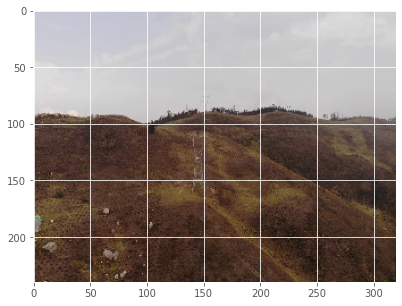

In [0]:
#Labels             Classes             OneHot     
#Nothing:              0                [1 0]
#Inspecting:           1                [0 1]

print("Labels            Classes                 OneHot")
print("Nothing              0                    [1. 0.]")
print("Inspecting           1                    [0. 1.]")

#Image
num_de_imagen = 10020

print()
print("Output:                                   "+ str(yt[num_de_imagen]))

imagen =  train_img[num_de_imagen]
plt.imshow(imagen)
plt.show()

As we can see, the images in the dataset have a dimension of 240x320x3

In [0]:
#Get the shape of x_train
print('x_train shape:     ', xt.shape)
#Get the shape of y_train
print('y_train shape:     ', yt.shape)
#Get the shape of x_validation
print('x_validation shape:', xval.shape)
#Get the shape of y_validation
print('y_validation shape:', yval.shape)
#Get the shape of x_test
print('x_test shape:      ', xtest.shape)
#Get the shape of y_test
print('y_test shape:      ', ytest.shape)

x_train shape:      (15399, 240, 320, 3)
y_train shape:      (15399, 2)
x_validation shape: (3301, 240, 320, 3)
y_validation shape: (3301, 2)
x_test shape:       (3300, 240, 320, 3)
y_test shape:       (3300, 2)


## Model Setup

In [0]:
from keras.callbacks import ModelCheckpoint

#Inputs
inputs = Input(shape=img_shape, name='images')

#Nasnet Model
output = inception_v3.InceptionV3(include_top=False,weights=None, 
                                  input_shape=img_shape,
                                  classes = num_classes)(inputs)


#AveragePooling2D
output = AveragePooling2D(pool_size=(2, 2), strides=None, 
                          padding='valid',name='AvgPooling')(output)

#Flattened
output = Flatten(name='Flatten')(output)

#Dropout
output = Dropout(0.2,name='Dropout')(output)

#ReLU layer
output = Dense(10, activation = 'relu',name='ReLU')(output)

#Dense layer
output = Dense(num_classes, activation='softmax',name='softmax')(output)

#Checkpoint_path

# Create checkpoint callback
model_checkpoint = ModelCheckpoint(filepath="/content/drive/My Drive/Newinception/inceptionv3.h5",
                                   monitor='val_loss', save_best_only=True)

#Model
modelo = Model(inputs=inputs, outputs=output)

ADAM = Adam(lr=lrate)
modelo.compile(loss='categorical_crossentropy',optimizer=ADAM,
               metrics=['categorical_accuracy'])

#Summary
modelo.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 240, 320, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 6, 8, 2048)        21802784  
_________________________________________________________________
AvgPooling (AveragePooling2D (None, 3, 4, 2048)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 24576)             0         
_________________________________________________________________
Dropout (Dropout)            (None, 24576)             0         
_________________________________________________________________
ReLU (Dense)                 (None, 10)                245770    
_________________________________________________________________
softmax (Dense)              (None, 2)                 22  

## Traning

In [0]:
#Training Model

stad = modelo.fit({'images': xt}, {'softmax': yt}, batch_size=batch_size,
           epochs=num_epochs, validation_data=(xval, yval),shuffle=True, callbacks = [model_checkpoint])

Train on 15399 samples, validate on 3301 samples
Epoch 1/10
15390/15399 [============================>.] - ETA: 0s - loss: 0.1414 - categorical_accuracy: 0.9435

The primary use case is to automatically save checkpoints *during* and at *the end* of training. This way you can use a trained model without having to retrain it, or pick-up training where you left of—in case the training process was interrupted.

#### Checkpoint callback usage

Train the model and pass it the `ModelCheckpoint` callback:

In [0]:
from tensorflow.keras.models import load_model

modelo = load_model('/content/drive/My Drive/Newinception/inceptionv3.h5')

In [0]:
from sklearn.metrics import confusion_matrix

#Evaluate the model
puntuacion = modelo.evaluate(xtest,ytest,verbose=0)

print("Loss: " + str(round(puntuacion[0],4)) + " Accuracy: " + str(round(puntuacion[1],4)))

predIdxs = modelo.predict(xtest)
predIdxs = np.argmax(predIdxs, axis=1) # argmax for the predicted probability

#print(classification_report(ytest.argmax(axis=1), predIdxs,target_names=lb.classes_))

cm = confusion_matrix(ytest.argmax(axis=1), predIdxs)
total = sum(sum(cm))

acc = (cm[0, 0] + cm[1, 1]) / total

sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Loss: 0.0099 Accuracy: 0.9952
[[1673   14]
 [   2 1611]]
acc: 0.9952
sensitivity: 0.9917
specificity: 0.9988


##Predictions

(240, 320, 3)


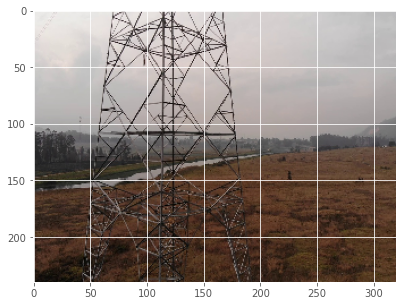

Labels            Classes                 OneHot
Nothing              0                    [1. 0.]
Inspecting           1                    [0. 1.]

Predictions:                              [[0. 1.]]


In [0]:
plt.figure(3)

Num_image = 1000

inputoimage = xt[Num_image]

print(inputoimage.shape)

x = inputoimage.reshape((-1, 240, 320, 3))

imagen =  xt[Num_image]
plt.imshow(imagen)
plt.show()

print("Labels            Classes                 OneHot")
print("Nothing              0                    [1. 0.]")
print("Inspecting           1                    [0. 1.]")

ynew = modelo.predict(x)
print()
print("Predictions:                              "+ str(np.round(ynew,2)))

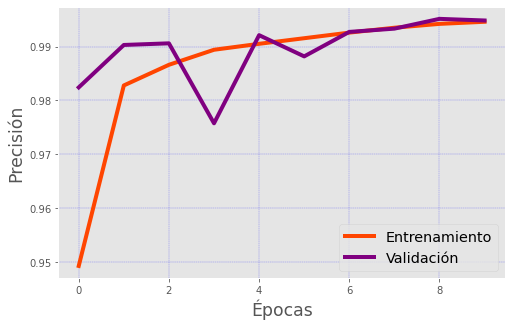

In [0]:
plt.figure(0)

plt.rcParams["figure.figsize"] = (8,5)

## explain
plt.style.use("ggplot")

plt.plot(stad.history['categorical_accuracy'],'orangered',linewidth=4)  
plt.plot(stad.history['val_categorical_accuracy'],'purple',linewidth=4)  
plt.xlabel("Épocas",fontsize = 'xx-large')  
plt.ylabel("Precisión",fontsize = 'xx-large')  
#plt.title("Training Accuracy vs Validation Accuracy",fontsize = 'xx-large')

plt.grid(color='b', ls = '-.', lw = 0.2)
plt.legend(['Entrenamiento','Validación'],fontsize = 'x-large')

plt.savefig("/content/drive/My Drive/Newinception/categorical_accuracy.png", bbox_inches = 'tight')

plt.show()  

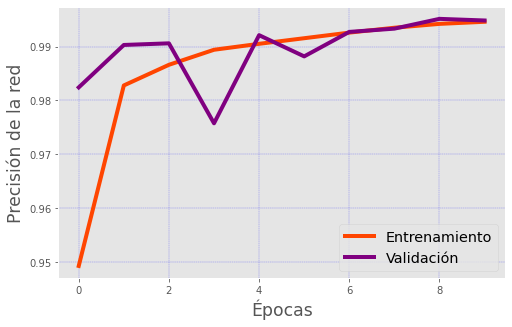

In [0]:
plt.figure(10)

plt.plot(stad.history['categorical_accuracy'],'orangered',linewidth=4)  
plt.plot(stad.history['val_categorical_accuracy'],'purple',linewidth=4)  
plt.xlabel("Épocas",fontsize = 'xx-large')  
plt.ylabel("Precisión de la red",fontsize = 'xx-large')  
#plt.title("Training Accuracy vs Validation Accuracy",fontsize = 'xx-large')

plt.grid(color='b', ls = '-.', lw = 0.2)
plt.legend(['Entrenamiento','Validación'],fontsize = 'x-large')

plt.savefig("/content/drive/My Drive/Newinception/categorical_accuracy2.png", bbox_inches = 'tight')

plt.show()  

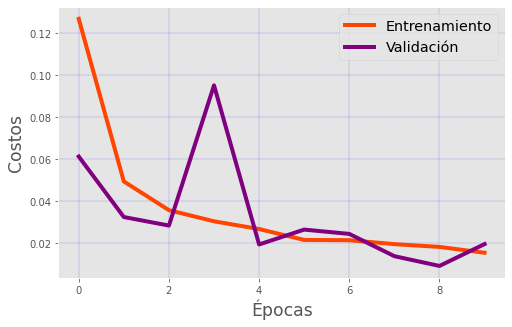

In [0]:
plt.figure(2)  

plt.plot(stad.history['loss'],'orangered',linewidth=4)  
plt.plot(stad.history['val_loss'],'purple',linewidth=4)  
plt.xlabel("Épocas",fontsize = 'xx-large')  
plt.ylabel("Costos",fontsize = 'xx-large')  
#plt.title("Training Loss vs Validation Loss",fontsize = 'xx-large')  

plt.grid(color='b', ls = '-.', lw = 0.2)
plt.legend(['Entrenamiento','Validación'],fontsize = 'x-large')

plt.savefig("/content/drive/My Drive/Newinception/Loss.png", bbox_inches = 'tight')

plt.show()  

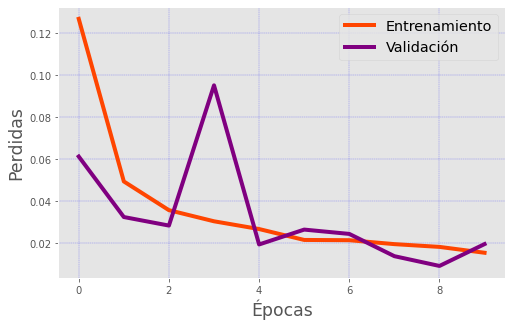

In [0]:
plt.figure(20)  

plt.plot(stad.history['loss'],'orangered',linewidth=4)  
plt.plot(stad.history['val_loss'],'purple',linewidth=4)  
plt.xlabel("Épocas",fontsize = 'xx-large')  
plt.ylabel("Perdidas",fontsize = 'xx-large')  
#plt.title("Training Loss vs Validation Loss",fontsize = 'xx-large')  

plt.grid(color='b', ls = '-.', lw = 0.2)
plt.legend(['Entrenamiento','Validación'],fontsize = 'x-large')

plt.savefig("/content/drive/My Drive/Newinception/Loss2.png", bbox_inches = 'tight')

plt.show()

In [0]:
import pandas as pd

# Se organiza la Data 
data = {'acc_train': stad.history['categorical_accuracy'],'acc_val': stad.history['val_categorical_accuracy'],
        'loss_train': stad.history['loss'],'loss_val': stad.history['val_loss']}

df = pd.DataFrame(data, columns = ['acc_train','acc_val','loss_train','loss_val'])

df.to_excel('/content/drive/My Drive/Newinception/Data2.xlsx', sheet_name='Data')